# 6.6 Sourcing and Analyzing Time Series Data

### This script contains the following points:

#### 1. Importing Libraries
#### 2. Importing Data
#### 3. Data Wrangling, Subsetting, and Cleaning
        Reason for subset
#### 4. Time-Series Analysis: Decomposition
        Decomposition Analysis
#### 5. Time-Series Analysis: Check for Stationarity
        Interpretation
#### 6. Stationarize the Data
        Interpretation
#### 7. BONUS: Forecasting with ARIMA
        Interpretation

## 1. Importing Libraries

In [1]:
import quandl
import nasdaqdatalink
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import statsmodels.api as sm 
import os
import warnings

# Disable deprecation warnings
warnings.filterwarnings("ignore")

# Plot styling option
plt.style.use('fivethirtyeight')

## 2. Importing Data

In [2]:
# Configure API key 
nasdaqdatalink.ApiConfig.api_key = 'skgw4LoKyB1U6RCy5_VJ'

In [3]:
# Import IMF Macroeconomic Statistics data, 

data = nasdaqdatalink.get_table('QDL/ODA', indicator='USA_PPPGDP')

## 3. Data Wrangling, Subsetting, and Cleaning

In [4]:
# Check the output
data.head(5)

# Data includes 5 forecasted years

,indicator,date,value
None,,,
0,USA_PPPGDP,2028-12-31,32349.658
1,USA_PPPGDP,2027-12-31,31091.594
2,USA_PPPGDP,2026-12-31,29902.871
3,USA_PPPGDP,2025-12-31,28765.960
4,USA_PPPGDP,2024-12-31,27741.123


In [5]:
# Check the shape
data.shape

(49, 3)

In [6]:
data = data.sort_values(by = ['date'])

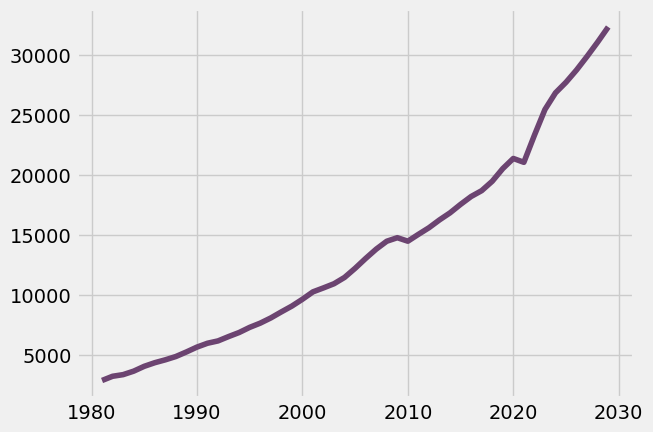

In [7]:
# Plot the data
plt.plot('date', 'value', data = data, color = '#6C4471')

In [8]:
# Subset the data to only include observed data
data2 = data.loc[(data['date'] >= '1980-01-01') & (data['date'] < '2024-07-05')]

In [9]:
# Check the shape
data2.shape

(44, 3)

In [10]:
from datetime import datetime

data2['datetime'] = pd.to_datetime(data2['date']) # Create a datetime column from "Date.""

In [11]:
data2.dtypes

indicator            object
date         datetime64[ns]
value               float64
datetime     datetime64[ns]
dtype: object

### Reason for subset:
        We want to retain as much of the data as possible, since the values were only taken yearly. But we also 
        want to not include any of the forecast data. So we subset the data to exclude the 5 forecast values, 
        and include everything else (only starting from 1980)

In [12]:
# Plot the data subset
plt.plot(data2, color = '#6C4471')...

SyntaxError: invalid syntax (2227281955.py, line 2)

In [ ]:
# Check for missing values
data2.isnull().sum() 

In [ ]:
# Check for duplicated values
dups = data2.duplicated()
dups.sum()

## 4. Time-Series Analysis: Decomposition

In [ ]:
# Use an additive model to decompose the data
decomposition = sm.tsa.seasonal_decompose(data2, model='additive', period = 1)

In [ ]:
from matplotlib.pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

In [ ]:
# Plot the decomposed components
decomposition.plot()
plt.show()

### Decomposition Analysis:
        The data does trend upwards over time, but it doesn't show any signs of seasonality or noise. I did not 
        have any expectations of the seasonality of this data coming into the analysis, but it is surprising 
        that both the seasonality and noise are consistently zero. This should mean that the data should be 
        close to stationarity, if not already there.

## 5. Time-Series Analysis: Check for Stationarity

In [ ]:
# Import the adfuller() function
from statsmodels.tsa.stattools import adfuller 

# Define the function
def dickey_fuller(timeseries):
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag = 'AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data2['value'])

In [ ]:
# Import the autocorrelation and partial correlation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot out autocorrelations
plot_acf(data2, color = '#6C4471')
plt.show()

### Interpretation:
        Although there are not too many autocorrelations in this time series, it is not stationary. The test 
        statistic is well above the critical values. So at least one round of transformations to force 
        stationarity is needed.

## 6. Stationarize the Data

In [ ]:
# Use a log transformation to stationarize the data
def log_stat(value):
    return math.log(value)

data_diff = data2['value'].apply(log_stat)

In [ ]:
# Remove any resulting null values
data_diff.dropna(inplace = True)
data_diff.head()

In [ ]:
# Convert the series into a dataframe
data_diff = pd.DataFrame(data_diff)

In [ ]:
# Plot the stationarized data
plt.figure(figsize = (15,5), dpi = 100)
plt.plot(data_diff, color = '#6C4471')

In [ ]:
# Perform a stationarity check
dickey_fuller(data_diff)

# The test statistic is below all critical values

In [ ]:
# Plot out autocorrelations
plot_acf(data_diff)
plt.show()

### Interpretation:
        The autocorrelation still looks the same. But now the the test statistic of the Dickey-Fuller test is 
        below the critical value (5%). This data is ready to move on to forecast modeling. 

## 7. BONUS: Forecasting with ARIMA

In [ ]:
# Plot partial autocorrelations to determine parameter p
plot_pacf(data_diff)
plt.figure(figsize = (15,15), dpi = 300)
plt.show()

#### There are two high positive bars that indicate correlations. We'll make p = 2.

In [ ]:
# Plot autocorrelations to determine parameter q
plot_acf(data_diff)
plt.figure(figsize = (15,5), dpi = 100)
plt.show()

#### There are five significant correlations that go beyond the blue border. We will try q = 3.

In [ ]:
# Split the data
train = data_diff['value'][:31]
test = data_diff['value'][30:]

In [ ]:
# Plot the data subset
plt.plot(train, label = 'training', color = '#6C4471')
plt.plot(test, label = 'test', color = '#B9839A')
plt.legend(loc = 'upper left', fontsize = 16)

In [ ]:
# Import the model you need
from statsmodels.tsa.api import ARIMA

model = ARIMA(train, order = (2, 1, 3))  
fitted = model.fit()  
print(fitted.summary()) # Check model summary

In [ ]:
# Forecast the data using the model
fc = fitted.forecast(13, alpha = 0.05)  # 95% confidence interval
conf = fitted.forecast(13, alpha = 0.05)

In [ ]:
# Calculate the standard error of the forecast data
se = fc.sem()

In [ ]:
# Create a new dataframe to keep track of the confidence interval values
d = {'lower': fc, 'upper': fc}
confidence_intervals = pd.DataFrame(data = d)

In [ ]:
# Define a function to add/subtract the standard error from the forecast values
def lower_interval(value):
    return value - (se * 2)

def upper_interval(value):
    return value + (se * 2)

# Calculate the confidence intervals
confidence_intervals['lower'] = confidence_intervals['lower'].apply(lower_interval)
confidence_intervals['upper'] = confidence_intervals['upper'].apply(upper_interval)

In [ ]:
# Check the output
confidence_intervals

In [ ]:
# Plot everything together
plt.figure(figsize = (12,8), dpi = 100)
plt.plot(train, label = 'training', color = '#6C4471')
plt.plot(test, label = 'actual', color = '#B9839A')
plt.plot(fc, label = 'forecast', color = '#2B1F3C')
plt.plot(confidence_intervals['lower'], color = '#E8D2CC', alpha = 0.8)
plt.plot(confidence_intervals['upper'], color = '#E8D2CC', alpha = 0.8)
plt.fill_between(confidence_intervals.index, confidence_intervals['lower'], confidence_intervals['upper'], 
                 color = '#E8D2CC', alpha = 0.8)
plt.title('Forecast vs Actuals')
plt.legend(loc ='upper left', fontsize=14)
plt.show()

### Interpretation:
        After one round of log transformations, and adjusting the model parameters, I was able to get a 
        model that looks pretty close to forecasting the time series. The final model parameters were 
        p = 2, d = 1, q = 3.
        
        I am still unclear with how exactly these parameters affect the model and why changing the number could
        improve the model's fit. In addition, when I first looked at stationarization, differencing increased 
        the variance in the data to a point that the confidence interval of the forecast model would never have  
        covered the actual data. 